# 프로젝트

**프로젝트 제출 루브릭**

| 평가 기준 | 달성 여부 및 설명 |
|-----------|--------------------|
| 데이터셋 구성과 전처리를 통해 프로젝트 베이스라인 구성을 확인하였다.| MPII 데이터셋을 기반으로 1epoch에 30분 이내에 학습가능한 베이스라인을 구축하였다. |
| simplebaseline 모델을 정상적으로 구현하였다.| simplebaseline 모델을 구현하여 실습코드의 모델을 대체하여 정상적으로 학습이 진행되었다. |
| Hourglass 모델과 simplebaseline 모델을 비교분석한 결과를 체계적으로 정리하였다.| 두 모델의 pose estimation 테스트결과 이미지 및 학습진행상황 등을 체계적으로 비교분석하였다. |

## 목차 
1. Library & Path & Data
2. Visualize Dataset Samples (train)
3. Model & Train
4. Model Load & Visualize Loss/Metric
5. Visualize Model Predict (valid image)

# 간단 설명

---
## Data
MPII Human Pose Dataset 사용  

해당 keypoint 명칭들   

0 - 오른쪽 발목   
1 - 오른쪽 무릎   
2 - 오른쪽 엉덩이    
3 - 왼쪽 엉덩이   
4 - 왼쪽 무릎   
5 - 왼쪽 발목   
6 - 골반   
7 - 가슴(흉부)   
8 - 목   
9 - 머리 위   
10 - 오른쪽 손목   
11 - 오른쪽 팔꿈치   
12 - 오른쪽 어깨   
13 - 왼쪽 어깨   
14 - 왼쪽 팔꿈치   
15 - 왼쪽 손목   

---

## Model
1. Stacked Hourglass Network
2. SimpleBaseline

---

## Loss & Metric
1. MSELoss
    - 예측한 좌표와 실제 좌표 간 차이를 제곱하여 평균한 값으로, 위치 오차를 수치적으로 측정
    - Stacked Hourglass Network는 num_stack=4로 되어있기에, 4개의 loss를 구하고 더해지기에 SimpleBaseline 대비해서 대략 4배정도의 loss가 높은 듯 하다.
2. PCKh
    - 특정 관절이 기준 길이(head size 등)에 비해 허용 오차 이내에 위치하는지 비율로 측정한 정확도
    - PCKh@0.05를 사용 -> 현재 heatmap(64,64,16)크기에서 0.05인 5%이내, 즉 3 pixel 내에 관절 예측이 들어오는 비율로 정확도 (하드코딩 되어있음)

단순 distance로 할지 정확도 개념의 acc로 할지 고민 중에, 특정 범위 내로 들어오면 True로 하는 것도 어떻가 하다가 논문에서 PCK를 사용하는 것을 보고 적용함  

---

## 이미지에 관하여
학습 과정을 살펴보았다.  
훈련 데이터인 이미지에서 keypoint의 중심점으로 부터 해당 인물을 crop하고, 그 이미지를 학습하는 방식이다.  

추론은 이미지를 주고 알아서 keypoint를 적용하는 코드라, 이것도 crop하고 적용하는 방식으로 진행  

즉, OCR 때랑 같은 상황으로 보편적으로 이미지가 주어졌을때 직접 detection은 하지 않고(easyocr 사용해서 detection함), recognition만 적용하는 process와 동일.   

틀 자체를 이대로 진행하기에, label이 없는 이미지가 주어졌을때 인식하지 못할 것으로 예상됨.   
(이렇게 모델을 구성해보고, 진행하고 학습하고 시각화하는 거에 의의를 담음)  

---

## 학습 속도
1. 기존 Node의 기준으로 학습한다면  
Batch_size=2 기준 -> 1epoch에 45분  

다만 batch마다의 연산속도는 굉장히 빠른것으로 보아 단순히 batch_size를 키우기만 하면 어느정도 절약될 것으로 보여졌음   

2. Batch_size=16 기준 -> 1epoch에 13분  
(위 시간은 Stacked Hourglass Network 모델 기준. SimpleBaseline은 보다 구조가 단순하여 속도는 더 빠름)  

추가로 더 빠르게 하고자 하면, AMP 기법도 적용해보면 될 거 같음.(비트도 적게 쓰면서 batch_size를 더 늘릴수 있게 됨)(Semantic Segmentation에서 사용해보고 설명 복붙해옴)   
AMP: Automatic Mixed Precision   
    - 필요한 곳에는 float32를 쓰고, 덜 중요한 곳에는 float16 (16비트)를 섞어서(Mixed) 사용하는 기술   
    - 성능에는 거의 영향을 안끼치면서, 속도를 높여줌 (U-Net++ 1epoch 기준 80초대에서 50초대로 줄여줌)   

---

## 모델 크기와 현 LMS의 하드웨어 비교

1. 현상황
위에서 Batch_size=16으로 두고 진행을 했음.  
터미널은 아니지만 LMS 노드에 들어오면 보이는 GPU, Path, MEM 사용량에서 MEM:100%라서 16이 최대로 생각했었음.  

터미널에서 nvidia-smi를 치면, GPU 연산 활용률: 99%, GPU Memory : 7,051 MiB / 15,360 MiB 사용 중   
결국 AMP와 현 상황을 보니 batch_size=32~64로 올려두 충분해 보임.  

GPU: NVIDIA Tesla T4    
VRAM (메모리): 15GB    
현재 사용량: ~7GB (Batch Size 16 기준)   
여유 공간: ~8GB (54%)    

2. Model 크기 (익숙치가 않아, Gemini와 함께 진행함)

|모델|	구조|	파라미터 수 (약)|	가중치 크기 (FP32)|
|-----------|--------------------|--------------------|--------------------|
|SimpleBaseline|	ResNet50 기반|	3,400만 개|	~130 MB|
|Stacked Hourglass|	4-Stack|	2,500만 개|	~100 MB|

VRAM(GPU Memory) 예상 사용량  
SimpleBaseline: 약 4 ~ 6 GB   
Stacked Hourglass: 약 6 ~ 8 GB (중간 히트맵 생성으로 인해 더 많이 필요)   

결론 batch_size=32로 해도 충분할 것으로 보임   

3. 결과
batch_size=32 로 할 경우에 생기는 문제점으로 -> shared memory 부족  
해결하기 위해서(기존에 4, True, 2 였음) -> num_workers=0, pin_memory=False, prefetch_factor=None   

기존 batch_size=16 -> 1batch에서 0.62s   
적용 batch_size=32 -> 1batch에서 0.59s    

빨라진줄 알았지만, batch 기준에서 보면 훨씬 빨라졌지만, DataLoader의 기능을 미적용시키니 각 batch에서 loader를 꺼내오는 시간이 늘어남.(이게 병목현상?)   
결국 총 1epoch 시간은 거의 유사함   

# 회고

## model 
1. Stacked Hourglass Network
    - num_stack=4
    - num_residual=1
2. SimpleBaseline

Batch_size = 32    
Learning Rate : 0.002(~10epoch) -> 0.001(10~30epoch) 

---

## Train

### 1. Stacked Hourglass Network

7 Epoch까지 batch_size=16으로 돌리다가, 8 epoch부터 batch_size=32로 바꾸고 학습 진행함.   
Loss 구하는 코드에서 Global_batch_size로 Loss를 나누는 행위가 존재함.   
batch_size를 2배 늘리면서, Loss가 2배 감소함.    

다만 SimpleBaseline과 Loss로만 비교하기에는, Hourglass 특성상 num_stack=4 parameter로 인해 네번의 Loss를 더하는 행위로 Loss자체는 높을수 밖에 없어보임.   

| Epoch | Train Loss | Val Loss | Train Acc | Val Acc | Saved Model |
|-------|------------|----------|-----------|---------|-------------|
| 1     | 1.3585     | 1.2507   | 0.3433    | 0.4692  | Best        |
| 2     | 1.2185     | 1.1999   | 0.4861    | 0.4990  | Best        |
| 3     | 1.1673     | 1.1687   | 0.5401    | 0.5535  | Best        |
| 4     | 1.1339     | 1.1306   | 0.5783    | 0.6013  | Best        |
| 5     | 1.1074     | 1.1294   | 0.6048    | 0.5787  | Best        |
| 6     | 1.0869     | 1.1155   | 0.6290    | 0.6338  | Best        |
| 7     | 1.0672     | 1.1168   | 0.6474    | 0.6310  |    -         |
| 8     | 0.5143     | 0.5454   | 0.6828    | 0.6559  | Best        |
| 9     | 0.5050     | 0.5434   | 0.6984    | 0.6621  | Best        |
| 10    | 0.4971     | 0.5399   | 0.7077    | 0.6665  | Best        |
| 11    | 0.4746     | 0.5479   | 0.7398    | 0.6548  | Best        |
| 12    | 0.4648     | 0.5496   | 0.7526    | 0.6831  |   -          |
| 13    | 0.4576     | 0.5437   | 0.7596    | 0.6939  | Best        |
| 14    | 0.4515     | 0.5485   | 0.7675    | 0.6893  |    -         |
| 15    | 0.4447     | 0.5519   | 0.7723    | 0.6954  |    -         |
| 16    | 0.4381     | 0.5548   | 0.7782    | 0.6852  | -        |
| 17    | 0.4323     | 0.5602   | 0.7850    | 0.6936  |    -         |
| 18    | 0.4263     | 0.5596   | 0.7897    | 0.6717  |   -          |
| 19    | 0.4228     | 0.5597   | 0.7947    | 0.6940  |    -         |
| 20    | 0.4014     | 0.5642   | 0.8123    | 0.6964  |   -          |
| 21    | 0.4142     | 0.5538   | 0.8021    | 0.6952  | -        |
| 22    | 0.4097     | 0.5590   | 0.8041    | 0.6882  |    -         |
| 23    | 0.4065     | 0.5722   | 0.8066    | 0.6912  |    -         |
| 24    | 0.4016     | 0.5582   | 0.8107    | 0.6884  |     -        |
| 25    | 0.3811     | 0.5638   | 0.8287    | 0.6917  |      -       |
| 26    | 0.3744     | 0.5688   | 0.8350    | 0.7024  |     -        |
| 27    | 0.3707     | 0.5792   | 0.8383    | 0.6987  |     -        |
| 28    | 0.3669     | 0.5775   | 0.8406    | 0.6938  |     -        |
| 29    | 0.3664     | 0.5762   | 0.8413    | 0.6956  |     -        |
| 30    | 0.3654     | 0.5747   | 0.8417    | 0.6990  |     - |

### 2. SimpleBaseline

| Epoch | Train Loss | Val Loss | Train Acc | Val Acc | Saved Model |
|-------|------------|----------|-----------|---------|-------------|
| 1     | 0.1828     | 0.1674   | 0.2327    | 0.3466  | Best        |
| 2     | 0.1601     | 0.1588   | 0.3606    | 0.3341  | Best        |
| 3     | 0.1529     | 0.1535   | 0.4132    | 0.4470  | Best        |
| 4     | 0.1483     | 0.1481   | 0.4478    | 0.4688  | Best        |
| 5     | 0.1449     | 0.1489   | 0.4714    | 0.4672  |      -       |
| 6     | 0.1418     | 0.1450   | 0.4913    | 0.4900  | Best        |
| 7     | 0.1394     | 0.1462   | 0.5056    | 0.4737  |      -       |
| 8     | 0.1372     | 0.1436   | 0.5185    | 0.4909  | Best        |
| 9     | 0.1350     | 0.1414   | 0.5289    | 0.5077  | Best        |
| 10    | 0.1330     | 0.1409   | 0.5428    | 0.5231  | Best        |
| 11    | 0.1264     | 0.1373   | 0.5736    | 0.5592  | Best        |
| 12    | 0.1234     | 0.1375   | 0.5898    | 0.5698  |      -       |
| 13    | 0.1213     | 0.1386   | 0.5992    | 0.5667  | -       |
| 14    | 0.1191     | 0.1382   | 0.6074    | 0.5741  |      -       |
| 15    | 0.1127     | 0.1376   | 0.6280    | 0.5895  |      -       |
| 16    | 0.1161     | 0.1381   | 0.6233    | 0.5887  | -        |
| 17    | 0.1148     | 0.1388   | 0.6292    | 0.5890  |      -       |
| 18    | 0.1129     | 0.1397   | 0.6347    | 0.5875  |      -       |
| 19    | 0.1115     | 0.1397   | 0.6409    | 0.5879  |      -       |
| 20    | 0.1046     | 0.1396   | 0.6582    | 0.6011  |      -       |
| 21    | 0.1085     | 0.1408   | 0.6503    | 0.5924  | -        |
| 22    | 0.1073     | 0.1417   | 0.6557    | 0.5954  |      -       |
| 23    | 0.1060     | 0.1414   | 0.6584    | 0.5945  |      -       |
| 24    | 0.1046     | 0.1421   | 0.6663    | 0.5969  |      -       |
| 25    | 0.0976     | 0.1424   | 0.6793    | 0.6121  |      -       |
| 26    | 0.0949     | 0.1430   | 0.6890    | 0.6131  |      -       |
| 27    | 0.0933     | 0.1438   | 0.6915    | 0.6151  |      -       |
| 28    | 0.0922     | 0.1436   | 0.6946    | 0.6148  |      -       |
| 29    | 0.0917     | 0.1441   | 0.6961    | 0.6150  |      -       |
| 30    | 0.0918     | 0.1439   | 0.6963    | 0.6163  |      -       |

### 3. 비교 시각화

두 모델다 초기 4 epoch까지는 train과 valid가 겹치면서 Loss와 Acc가 같이 등락을 함.    

Hourglass는 표랑 시각화를 같이 보면 11epoch까지는 train과 val 모두 천천히 loss가 감소    
11epoch이후부터 train loss는 꾸준히 하락하지만, val loss는 다시 천천히 증가하는 현상 발생    
Acc는 5 ~ 10 Epoch에서 빠르게 증가하지만, 이후 epoch부터는 train acc는 꾸준히 천천히 증가하는 추세, val acc의 경우 0.69 ~ 0.7 사이에서 계속 머무는 현상이 발견     

SimpleBaseline은 11epoch까지는 train, val 모두 Loss는 하락, acc는 증가하는 추세를 보인다.    
다만 loss에서 11epoch 이후부터는 train은 꾸준히 비슷한 기울기로 하락하지만, val loss는 증가하는 추세가 뚜렷하게 보인다.     
acc같은 경우 11epoch 이후 train과 val 모두 천천히 증가하는 추세를 보인다.   

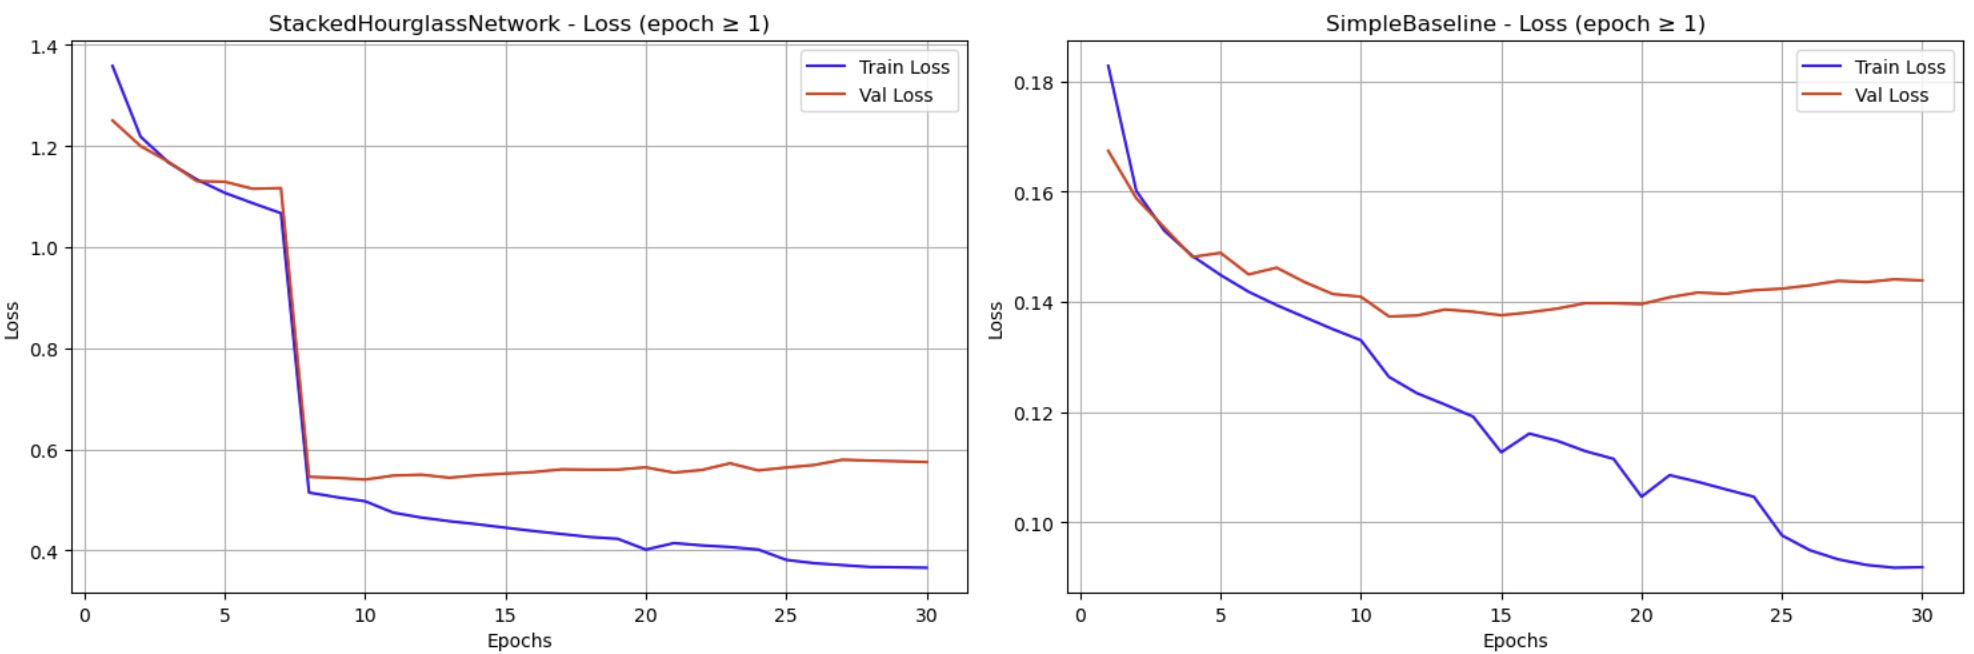
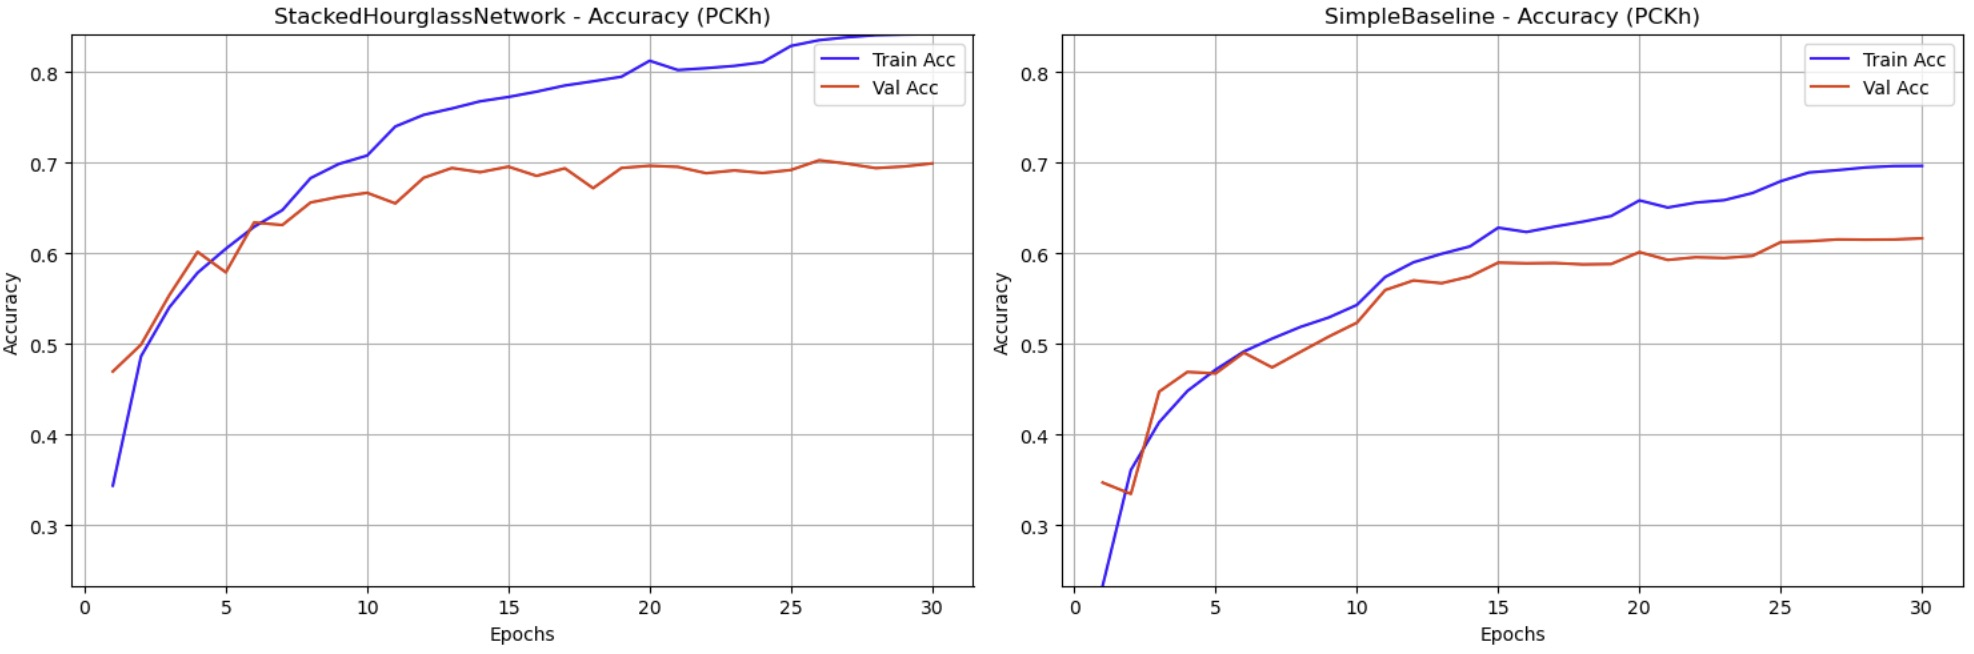


### 4. Keypoint 시각화
모델에서 추론한 (x,y)의 heatmap에 대한 confidence_threshold(0.3<)으로 이 threshold보다 작으면 해당 관절은 invalid 처리하게 진행.  
Valid Dataset으로 진행  


아래처럼 사람이 한명이거나, 사람이 보기에도 깔끔하게 Keypoint(or skeleton)이 형상을 띄우면, 모델 둘다 잘 예측하는 거 같다.  
다만 PCKh 성능을 보면, SimpleBaseline가 Hourglass보다 0.08 가량 낮기에 아래 이미지에서 오른쪽 무릎과 왼쪽 발목을 잘못 예측했다.   

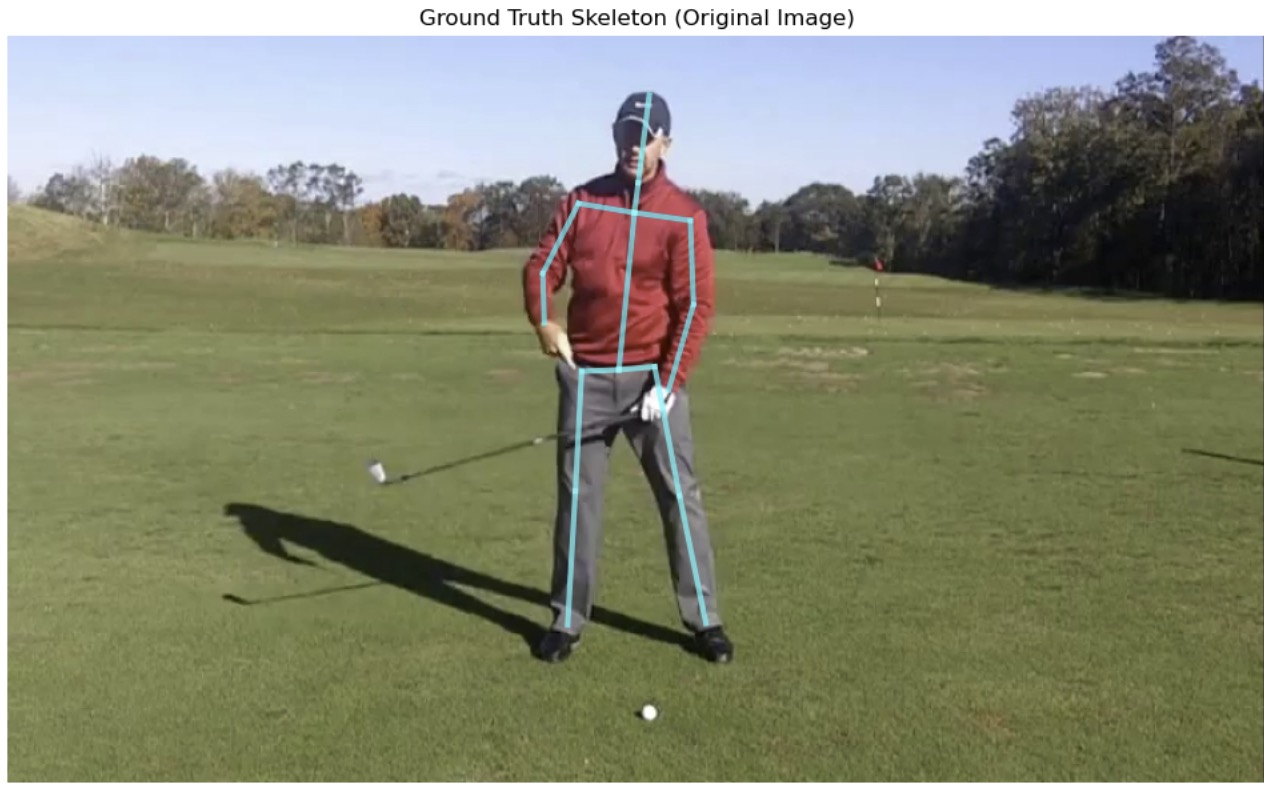
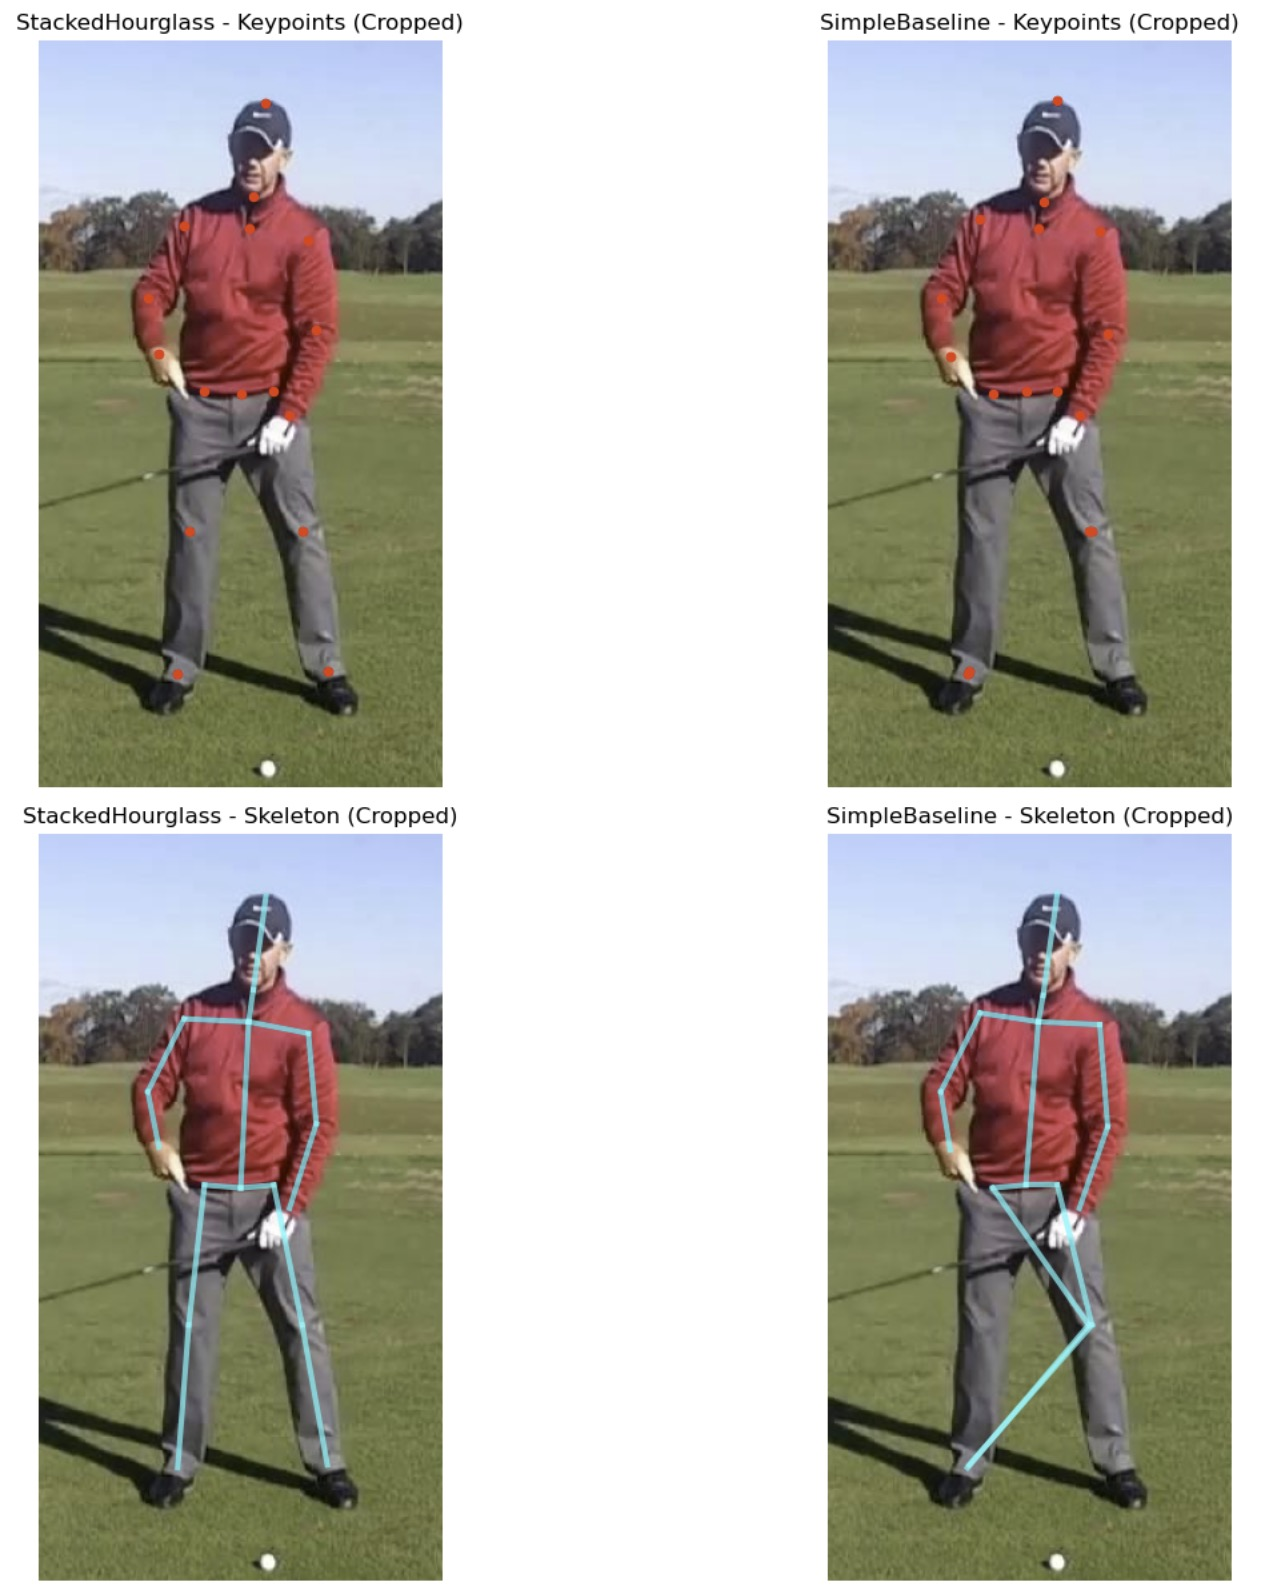

아래 이미지는 두 사람이 살짝 겹쳐있는 이미지이다.   
둘다 오른쪽 인물의 몸은 전부 잘 예측했지만, 사람이 겹쳐져 있는 오른쪽 팔은 잘 예측하지 못한다.  
Hourglass는 해당되지 않는 옆 인물의 팔을, 인식하고자 하던 인물의 팔로 인식을 하였다. (모델 입장에서는 skeleton을 보면 자연스럽다고 생각 했나봄)   
다만 SimpleBaseline은 오른쪽 팔에 대해 인식을 전혀 못하고 옆인물의 오른팔을 왔다갔다하면 skeleton이 이상해지는 현상이 생긴다.   

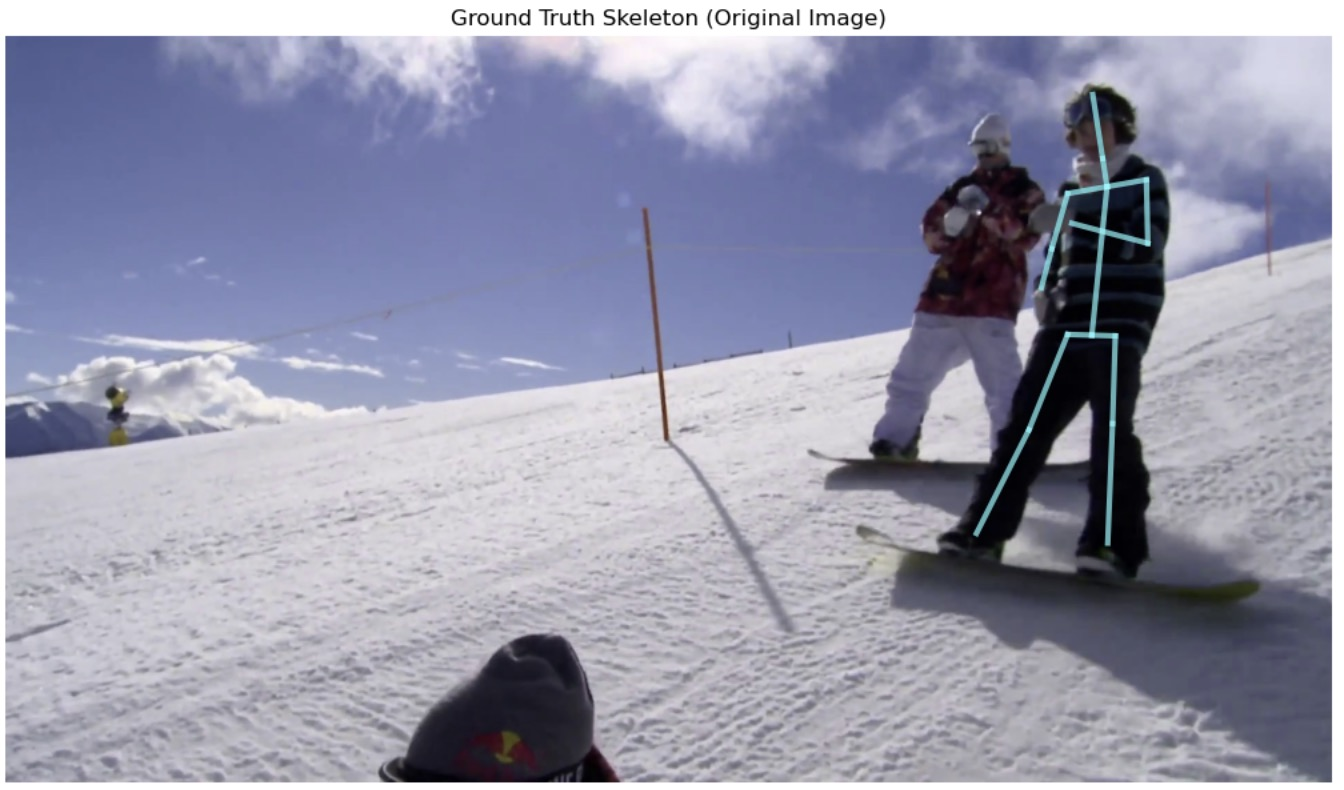
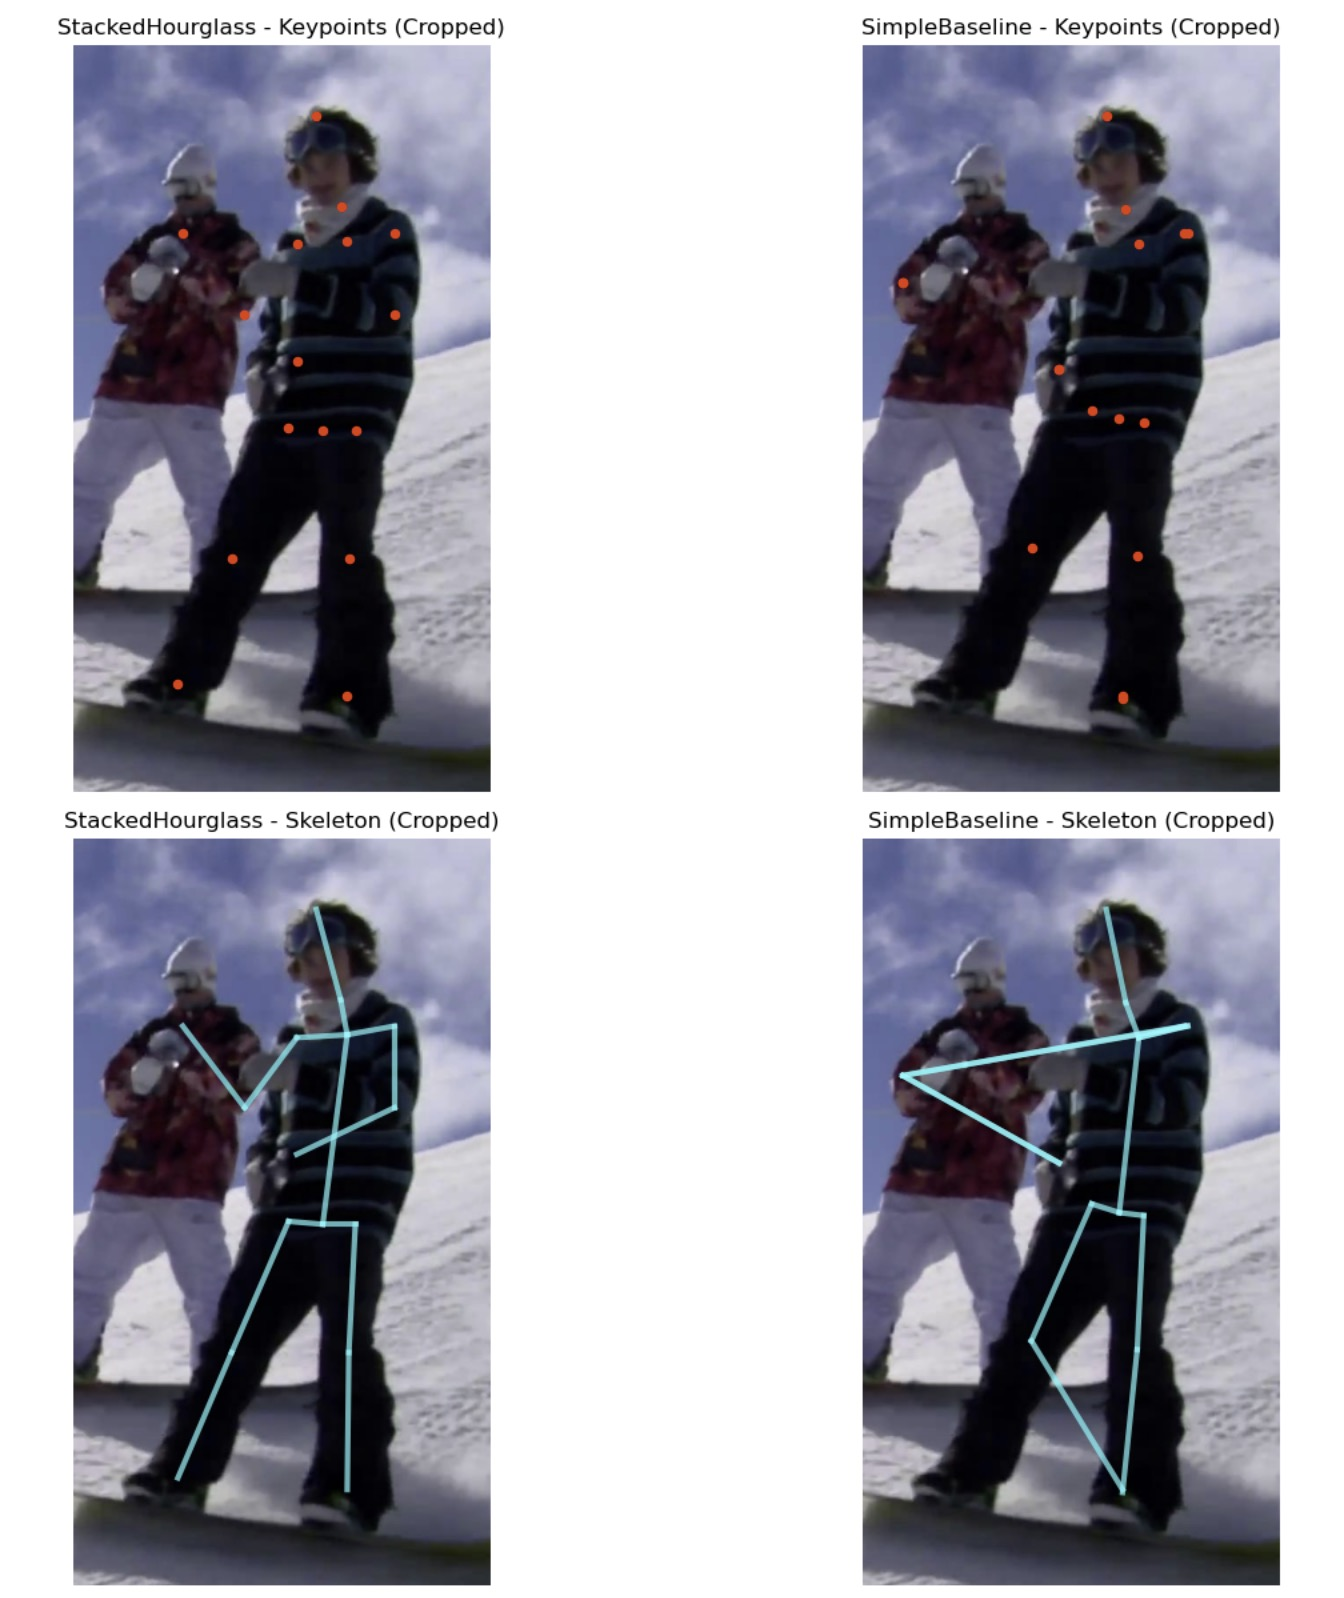

# 1. Library & Path & Data

In [1]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 34.4 MB/s eta 0:00:00:00:0100:01


In [ ]:
import os
import json
import pickle
import ray
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

# Import modularized functions
import src.train  
from src.annotation import parse_one_annotation
from src.utils import generate_ptexample, chunkify, crop_roi, generate_2d_gaussian, make_heatmaps
from src.ptrecord import build_pt_records
from src.dataset import MPIIDataset, Preprocessor, create_dataloader, show_dataset_samples
from src.model import StackedHourglassNetwork, SimpleBaseline
from src.train import train, Trainer
from src.visualization import (
    visualize_training_comparison,
    predict,
    draw_keypoints_on_image,
    draw_skeleton_on_image,
    compare_model_predictions
)

In [2]:
PROJECT_PATH = "/home/jovyan/work/project/GoingDeeper/Quest08/data"
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
PT_RECORD_PATH = os.path.join(PROJECT_PATH, 'ptrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2/train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2/validation.json')
IMAGE_SHAPE = (256, 256, 3)

src.train.MODEL_PATH = MODEL_PATH

print('Main notebook setup complete. Adjust constants above and run your pipeline.')

Main notebook setup complete. Adjust constants above and run your pipeline.


In [3]:
# Image의 label이 담긴 JSON 파일의 key와 value 들이 어떻게 구성되는지

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/home/jovyan/work/project/GoingDeeper/Quest08/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [4]:
def generate_mpii_records(train_json_path, val_json_path, image_path, pt_record_path, num_train_shards, num_val_shards):
    ray.init(ignore_reinit_error=True)

    if not os.path.exists(pt_record_path):
        os.makedirs(pt_record_path)

    def check_files_exist(split, shards):
        for i in range(shards):
            filename = '{}/{}_{}_of_{}.ptrecords'.format(
                pt_record_path,
                split,
                str(i + 1).zfill(4),
                str(shards).zfill(4),
            )
            if not os.path.exists(filename):
                return False
        return True

    if check_files_exist('train', num_train_shards) and check_files_exist('val', num_val_shards):
        print("PT Records already exist. Skipping generation.")
        return

    print('Start to parse annotations.')

    with open(train_json_path) as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, image_path)
            for anno in train_annos
        ]
        print('First train annotation: ', train_annotations[0])

    with open(val_json_path) as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, image_path)
            for anno in val_annos
        ]
        print('First val annotation: ', val_annotations[0])

    print('Start to build PT Records.')
    
    import src.ptrecord
    src.ptrecord.PT_RECORD_PATH = pt_record_path
    
    build_pt_records(train_annotations, num_train_shards, 'train')
    build_pt_records(val_annotations, num_val_shards, 'val')

    print('Successfully wrote {} annotations to PT Records.'.format(
        len(train_annotations) + len(val_annotations)))

num_train_shards = 64
num_val_shards = 8

generate_mpii_records(TRAIN_JSON, VALID_JSON, IMAGE_PATH, PT_RECORD_PATH, num_train_shards, num_val_shards)

2025-12-04 00:06:33,513	WARNING services.py:2137 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=5.00gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-12-04 00:06:33,677	INFO worker.py:2023 -- Started a local Ray instance.


PT Records already exist. Skipping generation.


/opt/conda/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=gcs_server) [2025-12-04 00:07:01,767 E 182 182] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-04 00:07:03,627 E 258 258] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=299) [2025-12-04 00:07:05,764 E 299 360] core_worker_process.cc:837: Failed to establish connection t

# 2. Visualize Dataset Samples (train)

Train Dataset Samples Visualization:
Dataset size: 22246


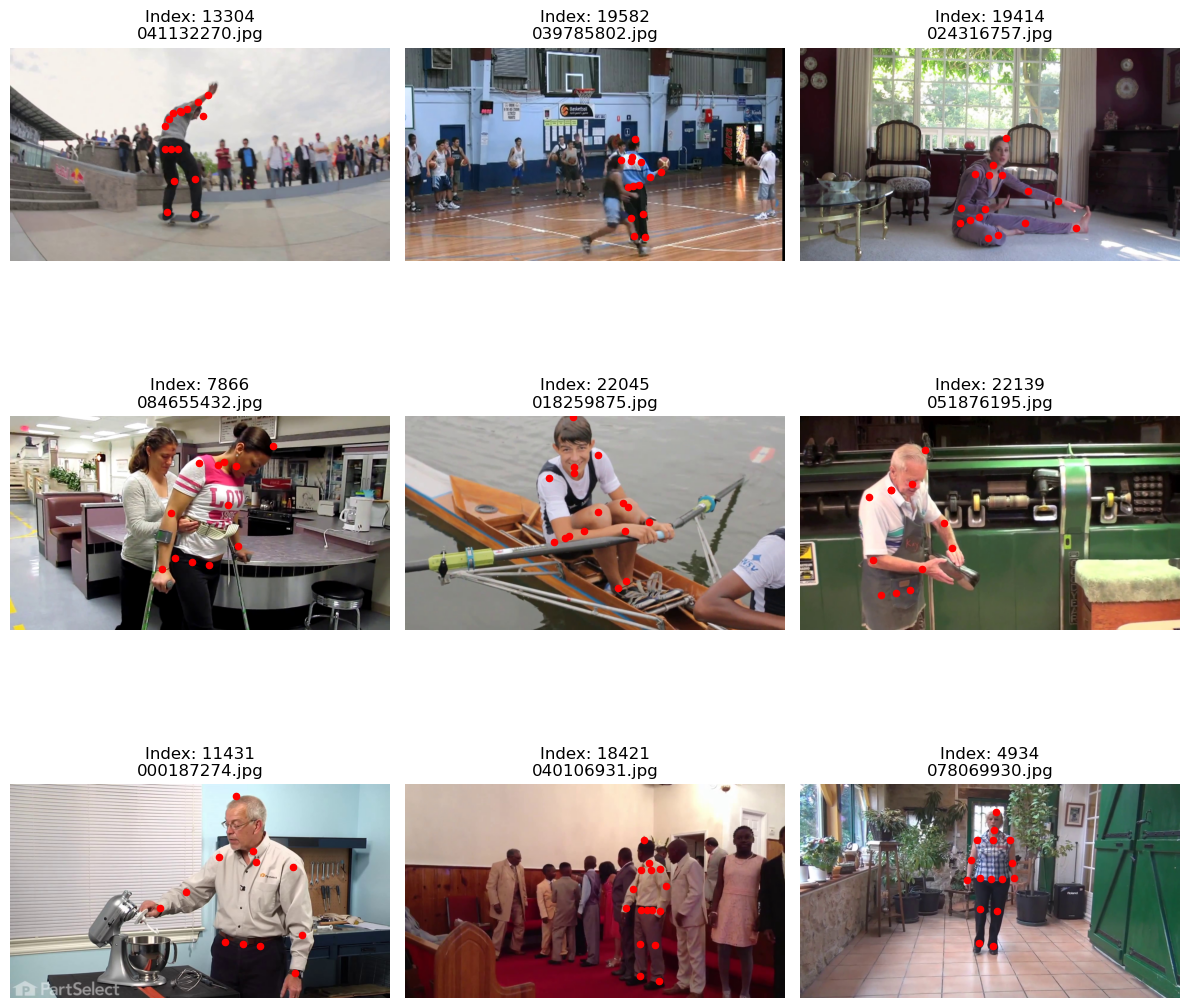

In [5]:
# 한 이미지에 여러사람이더라도, 학습 과정은 label이 있는 인물들의 중심점을 파악하고 box로 crop하여 진행하게 되어있음
# 아래 시각화도 그 방식이라, 한 이미지에 한 인물의 keypoint만 찍혀있음

print("Train Dataset Samples Visualization:")
show_dataset_samples(TRAIN_JSON, IMAGE_PATH)

# 3. Model & Train

In [6]:
num_heatmap = 16
epochs = 30
batch_size = 32
learning_rate = 0.001

[2025-12-04 00:07:05,909 E 127 296] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [19]:
# ==========================================
# 1. Stacked Hourglass Network 학습
# ==========================================
print("========== Training Stacked Hourglass Network ==========")
model_name = 'StackedHourglassNetwork'

model_hg = StackedHourglassNetwork(
    input_shape=IMAGE_SHAPE,
    num_stack=4,
    num_residual=1,
    num_heatmap=num_heatmap
)

history_hg = train(
    model_hg,
    model_name,
    epochs,
    learning_rate,
    num_heatmap,
    batch_size,
    TRAIN_JSON,
    VALID_JSON,
    IMAGE_PATH
)


========== Training Stacked Hourglass Network ==========
단일 GPU 혹은 CPU 사용
Found existing checkpoint for StackedHourglassNetwork. Attempting to resume...
Loading checkpoint '/home/jovyan/work/project/GoingDeeper/Quest08/data/models/StackedHourglassNetwork-latest.pt'
Loaded checkpoint '/home/jovyan/work/project/GoingDeeper/Quest08/data/models/StackedHourglassNetwork-latest.pt' (epoch 20)
Start training StackedHourglassNetwork from epoch 21...
Total batches in train_loader: 696
Total batches in val_loader: 93
Start epoch 21 with learning rate 0.001000
[Train] batch 1 loss 0.4345 acc 0.7676 time 0.6798s
[Train] batch 2 loss 0.3803 acc 0.8301 time 1.0234s
[Train] batch 3 loss 0.3779 acc 0.8340 time 0.5878s
[Train] batch 4 loss 0.4152 acc 0.7305 time 0.5864s
[Train] batch 5 loss 0.3902 acc 0.8008 time 0.5853s
[Train] batch 100 loss 0.4143 acc 0.8184 time 0.5936s
[Train] batch 200 loss 0.4005 acc 0.7793 time 0.5930s
[Train] batch 300 loss 0.3773 acc 0.8203 time 0.5908s
[Train] batch 400 loss 

In [20]:
# ==========================================
# 2. SimpleBaseline 학습
# ==========================================
model_name = 'simple_baseline'

model_sb = SimpleBaseline(num_heatmap=num_heatmap)

history_sb = train(
    model_sb,
    model_name,
    epochs,
    learning_rate,
    num_heatmap,
    batch_size,
    TRAIN_JSON,
    VALID_JSON,
    IMAGE_PATH
)

단일 GPU 혹은 CPU 사용
Found existing checkpoint for simple_baseline. Attempting to resume...
Loading checkpoint '/home/jovyan/work/project/GoingDeeper/Quest08/data/models/simple_baseline-latest.pt'
Loaded checkpoint '/home/jovyan/work/project/GoingDeeper/Quest08/data/models/simple_baseline-latest.pt' (epoch 20)
Start training simple_baseline from epoch 21...
Total batches in train_loader: 696
Total batches in val_loader: 93
Start epoch 21 with learning rate 0.001000
[Train] batch 1 loss 0.1057 acc 0.6582 time 0.2442s
[Train] batch 2 loss 0.0951 acc 0.6562 time 0.1809s
[Train] batch 3 loss 0.0998 acc 0.7012 time 0.1794s
[Train] batch 4 loss 0.1019 acc 0.6680 time 0.1801s
[Train] batch 5 loss 0.1016 acc 0.6504 time 0.1799s
[Train] batch 100 loss 0.1061 acc 0.6504 time 0.1815s
[Train] batch 200 loss 0.1115 acc 0.6348 time 0.1808s
[Train] batch 300 loss 0.1056 acc 0.6543 time 0.1796s
[Train] batch 400 loss 0.1022 acc 0.6621 time 0.1817s
[Train] batch 500 loss 0.0981 acc 0.6816 time 0.1814s
[Tra

# 4. Model Load & Visualize Loss/Metric 

In [7]:
# 이미 저장되어있는 best_model과 latest_model의 hitory 두개씩 꺼내옴
# latest_model의 hitory은 성능 시각화를 위해
# best_model과은 추론 시각화를 위해

def load_model_and_history(model_class, model_name, num_heatmap, input_shape=None):
    if input_shape:
        model = model_class(input_shape=input_shape, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
    else:
        model = model_class(num_heatmap=num_heatmap)
    
    best_path = os.path.join(MODEL_PATH, f'{model_name}-best.pt')
    latest_path = os.path.join(MODEL_PATH, f'{model_name}-latest.pt')
    
    if os.path.exists(best_path):
        checkpoint = torch.load(best_path, map_location='cpu')
        model.load_state_dict(checkpoint['state_dict'])
        print(f"Loaded weights for {model_name} from {best_path}")
    else:
        print(f"Warning: Best checkpoint not found for {model_name} at {best_path}")
        
    history = None
    if os.path.exists(latest_path):
        checkpoint = torch.load(latest_path, map_location='cpu')
        history = checkpoint.get('history', {})
        print(f"Loaded history for {model_name} from {latest_path}")
    else:
        print(f"Warning: Latest checkpoint not found for {model_name} at {latest_path}")
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    return model, history

print("Loading SimpleBaseline...")
model_sb, history_sb = load_model_and_history(SimpleBaseline, 'simple_baseline', num_heatmap=16)

print("Loading StackedHourglassNetwork...")
model_hg, history_hg = load_model_and_history(StackedHourglassNetwork, 'StackedHourglassNetwork', num_heatmap=16, input_shape=IMAGE_SHAPE)

Loading SimpleBaseline...


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Loaded weights for simple_baseline from /home/jovyan/work/project/GoingDeeper/Quest08/data/models/simple_baseline-best.pt
Loaded history for simple_baseline from /home/jovyan/work/project/GoingDeeper/Quest08/data/models/simple_baseline-latest.pt
Loading StackedHourglassNetwork...
Loaded weights for StackedHourglassNetwork from /home/jovyan/work/project/GoingDeeper/Quest08/data/models/StackedHourglassNetwork-best.pt
Loaded history for StackedHourglassNetwork from /home/jovyan/work/project/GoingDeeper/Quest08/data/models/StackedHourglassNetwork-latest.pt


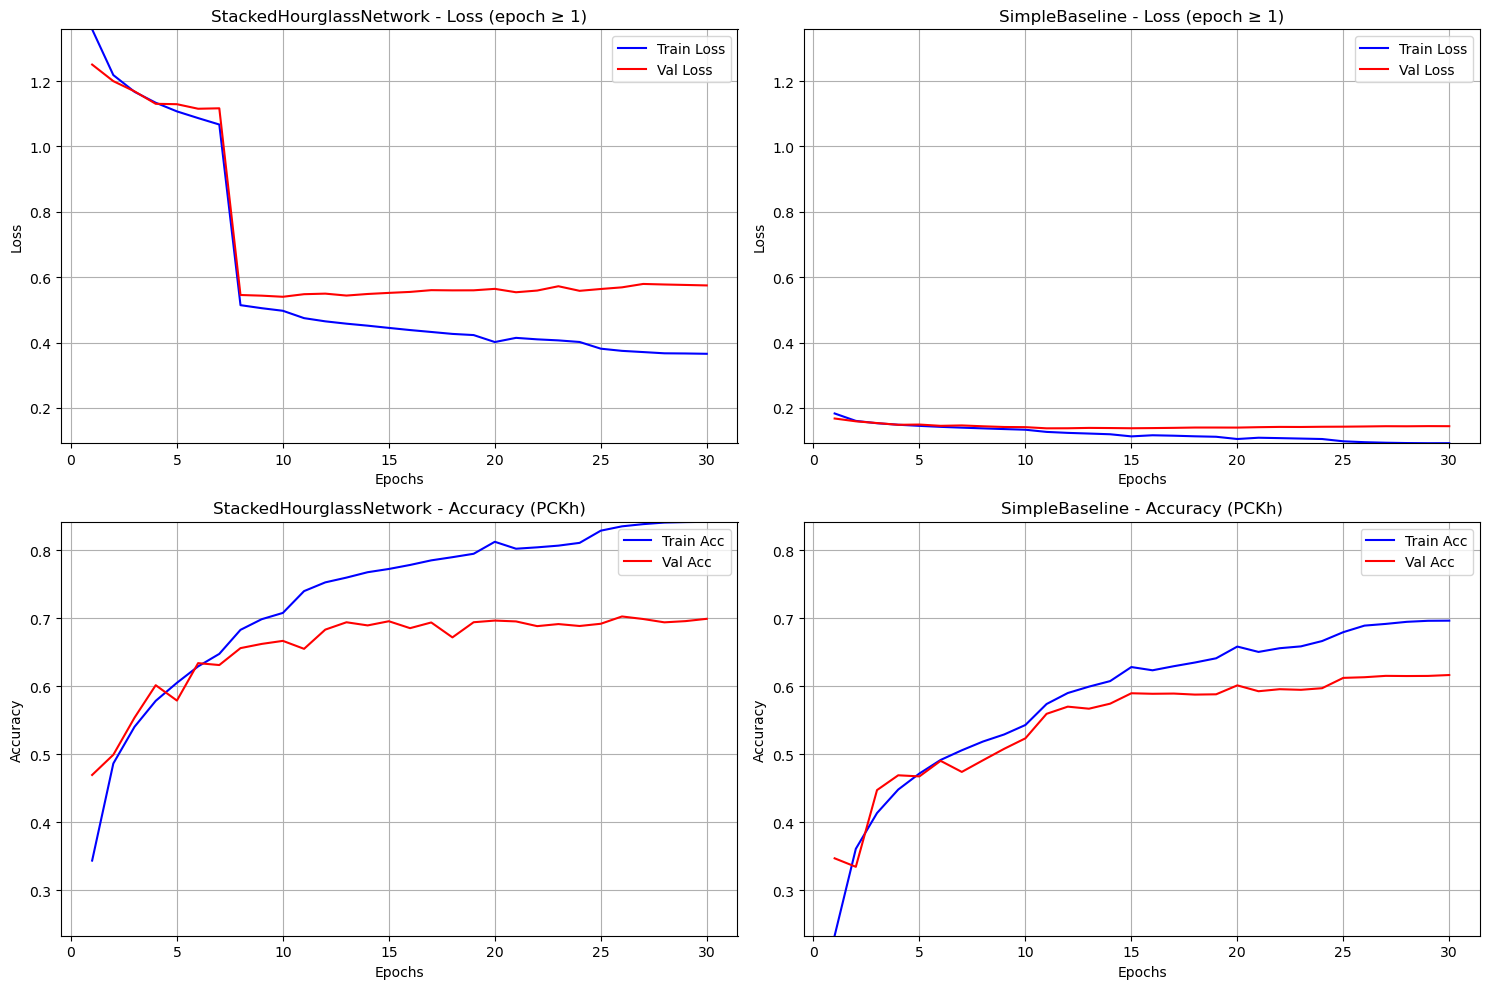

In [8]:
visualize_training_comparison(history_hg, history_sb, 'StackedHourglassNetwork', 'SimpleBaseline', epoch_start=1, y_lim=True)

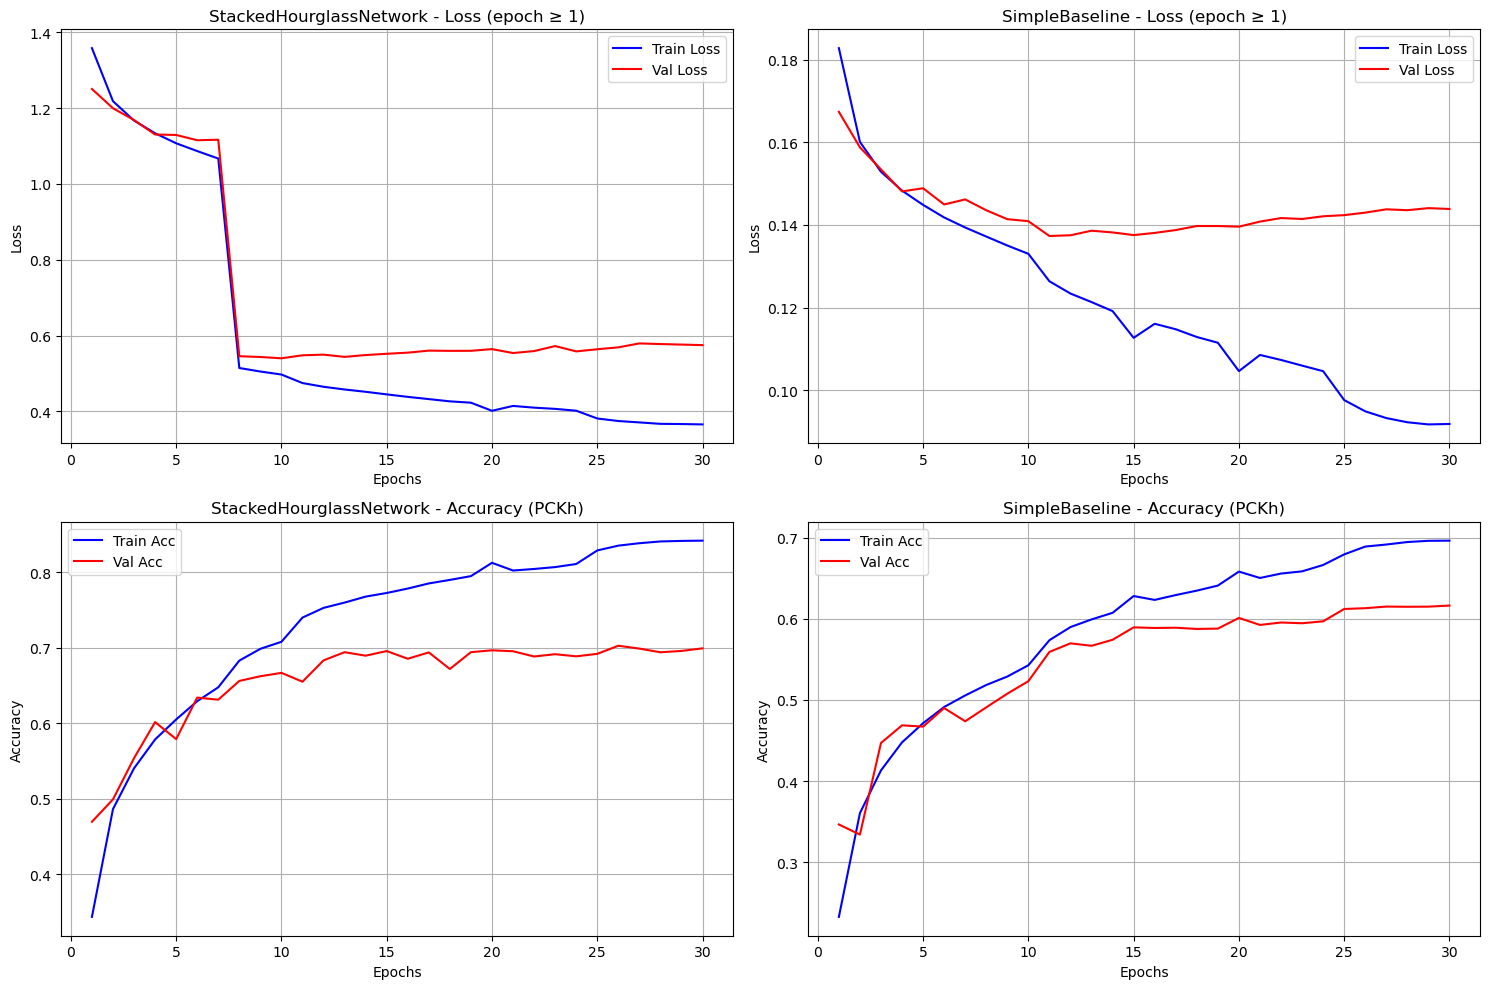

In [9]:
visualize_training_comparison(history_hg, history_sb, 'StackedHourglassNetwork', 'SimpleBaseline', epoch_start=1, y_lim=False)

# 5. Visualize Model Predict (valid image)

Comparing predictions between Stacked Hourglass and Simple Baseline...
Predicting on Validation Sample Index: 2398...


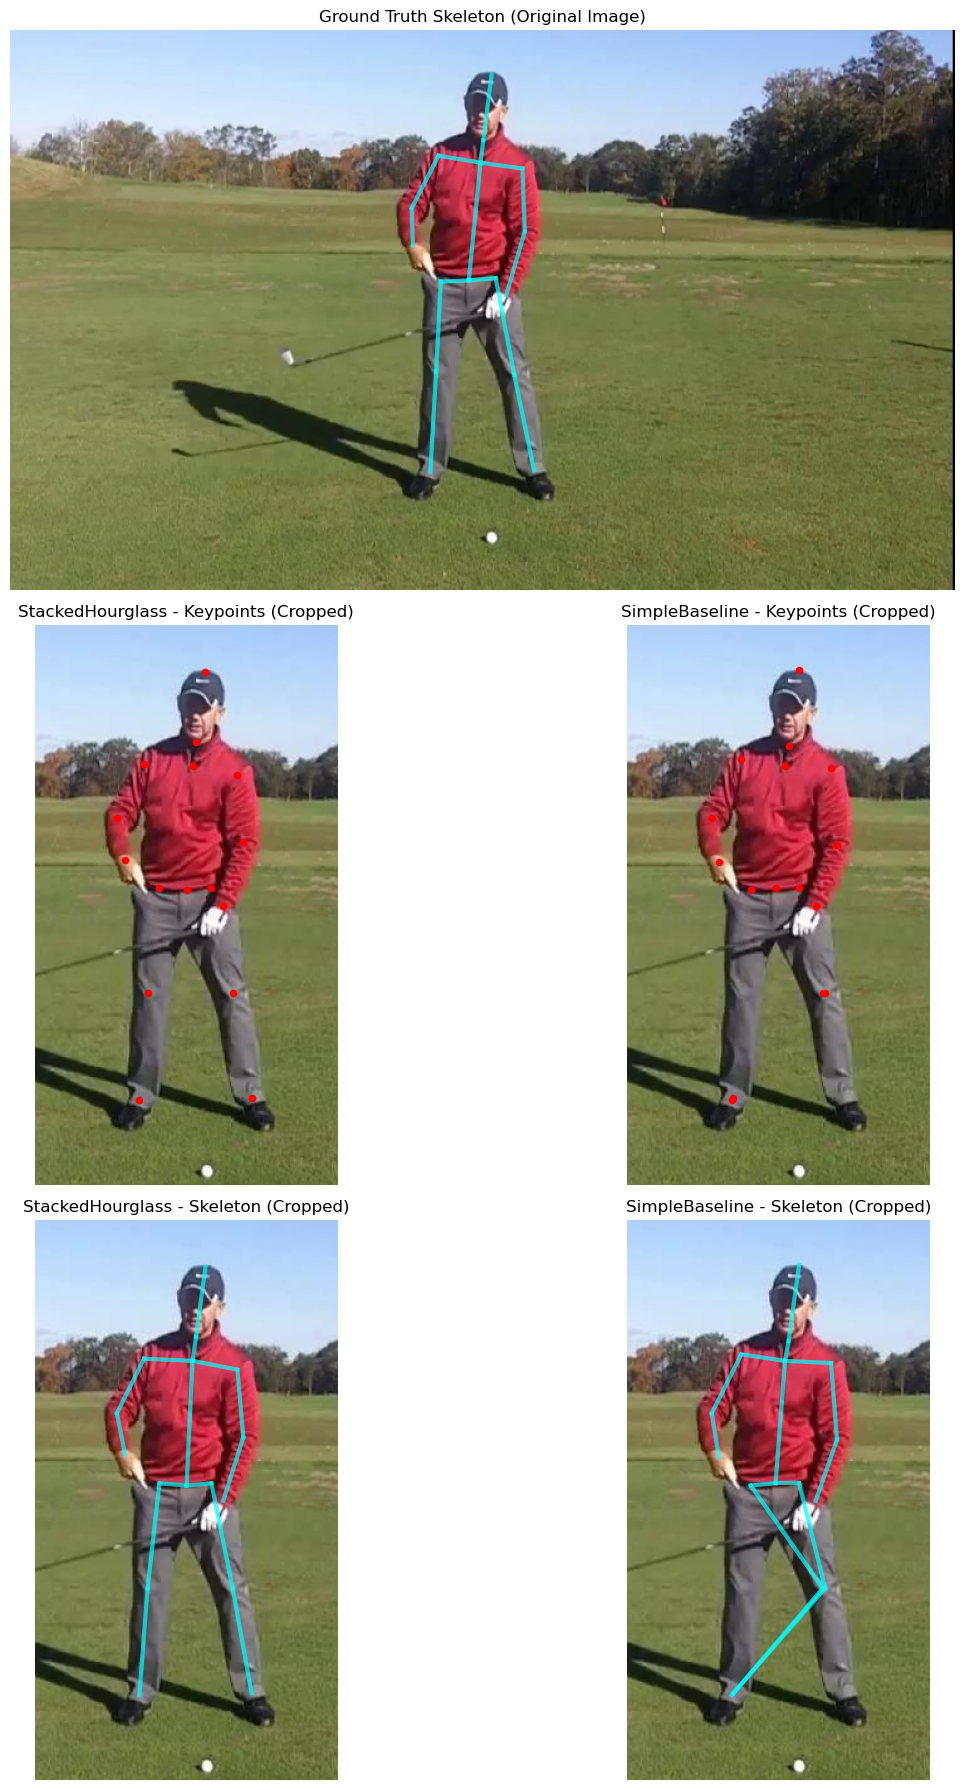

In [14]:
print("Comparing predictions between Stacked Hourglass and Simple Baseline...")
val_dataset = MPIIDataset(annotation_file=VALID_JSON, image_dir=IMAGE_PATH, transform=None)

compare_model_predictions(val_dataset, model_hg, model_sb)

Predicting on Validation Sample Index: 945...


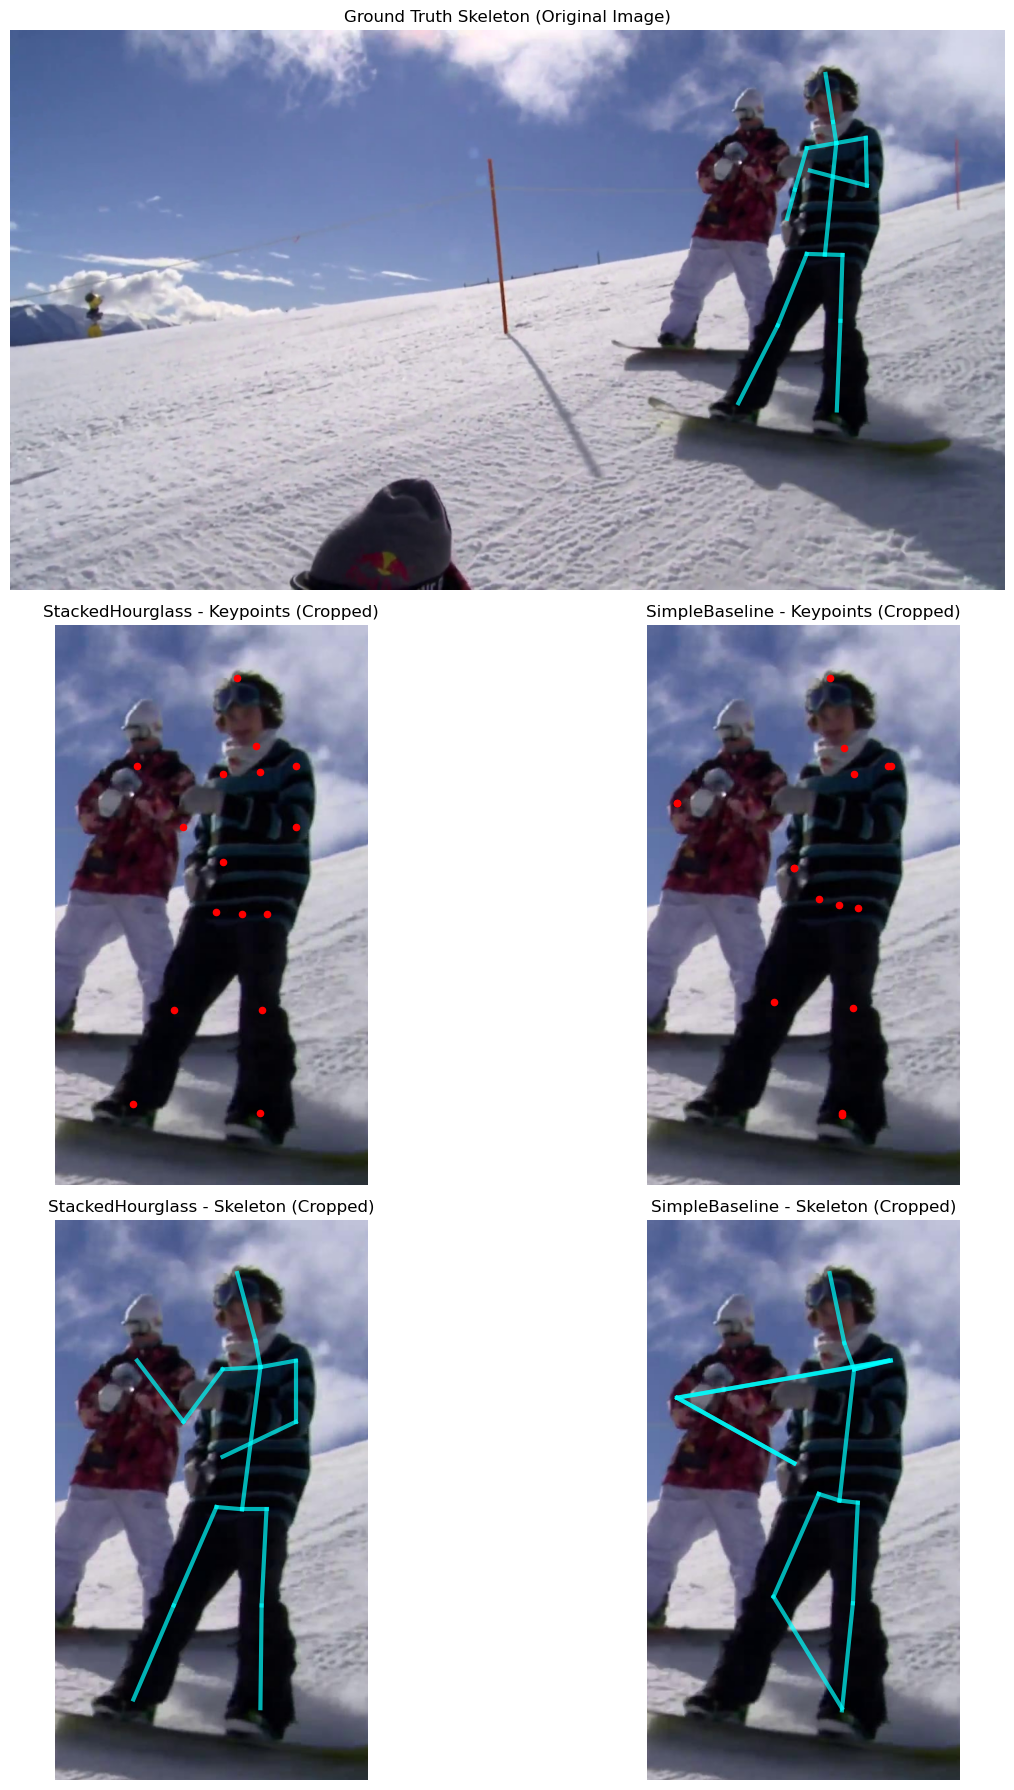

In [15]:
compare_model_predictions(val_dataset, model_hg, model_sb)